# **Retrieval Argumented Generation(RAG)- Local LLM with Free GPU via Google Colab**

With the increasing application of large language models in various scenarios, people realize that these models are not omnipotent. When generating dialogues (Shuster et al., 2021), the models often produce hallucinations, leading to inaccurate answers. Despite these large language models storing impressive knowledge within their parameters of a neural network, these hallucinated facts are frozen at the point of model training, making it infeasible to retrain the model. If we can bootstrap the model correctly, it can still be a powerful tool, and here comes the Retrieval Augmented Generator (RAG).

Retrieval-augmented generation (RAG) is an AI framework designed to enhance the quality of responses generated by large language models (LLM). It leverages external knowledge sources, typically knowledge graphs or other knowledge bases, such as Wikipedia, to augment the generation capabilities of these models. This integration enables the model to incorporate additional external information during text generation, thereby improving its accuracy and applicability while ensuring access to the latest reliable information.

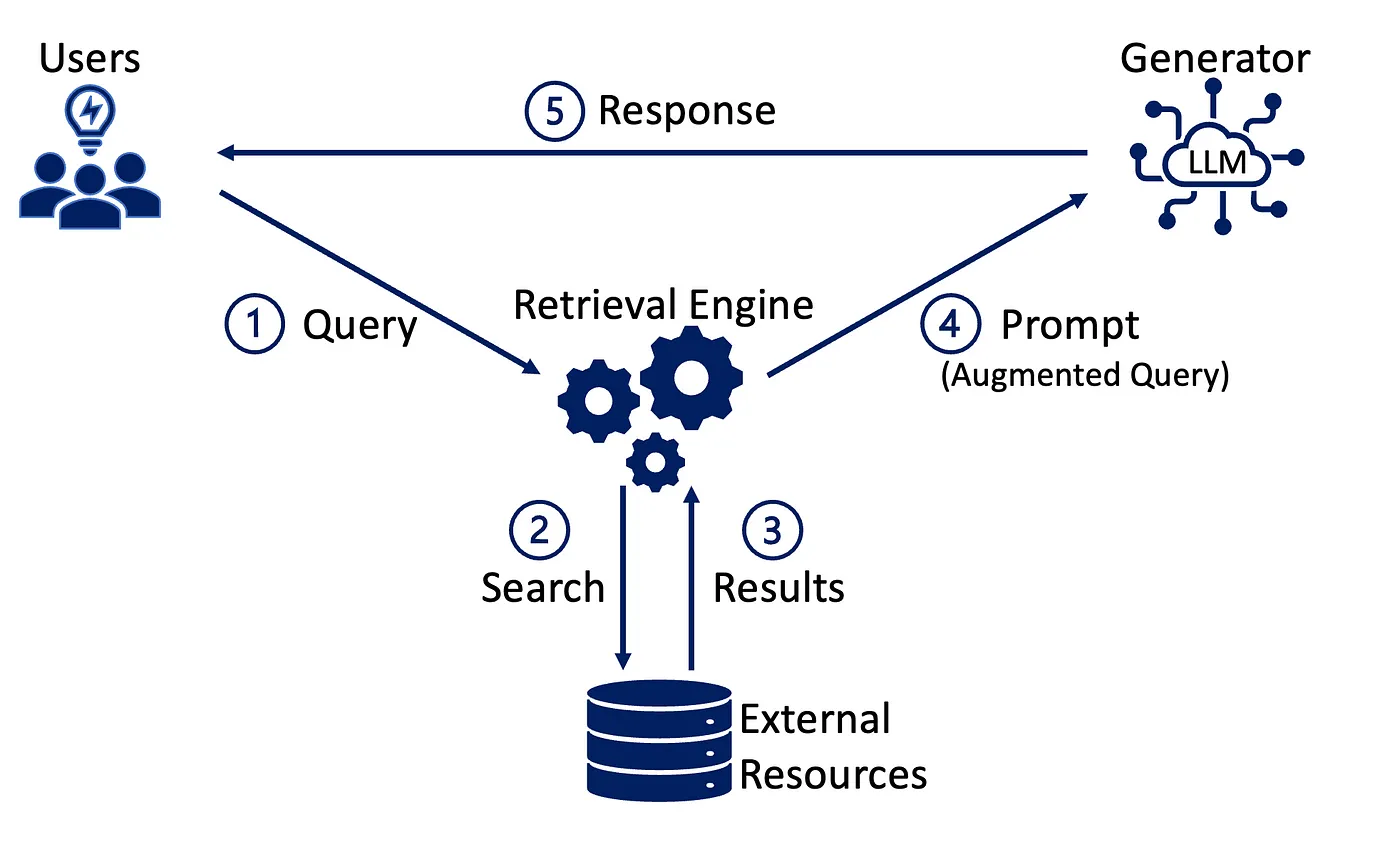

How does retrieval augmented generation (RAG) work?

RAG is about feeding language models with necessary information. Instead of asking LLM directly(like in general-purpose models), we first retrieve the very accurate data from our knowledge library that is well maintained and then use that context to return the answer. When the user sends a query(question) to the retriever, we use vector embeddings(numerical representations) to retrieve the requested document. Once the needed information is found from the vector databases, the result is returned to the user. This largely reduces the possibility of hallucinations and updates the model without retraining the model, which is a costly process. Here's a very simple diagram that shows the process.

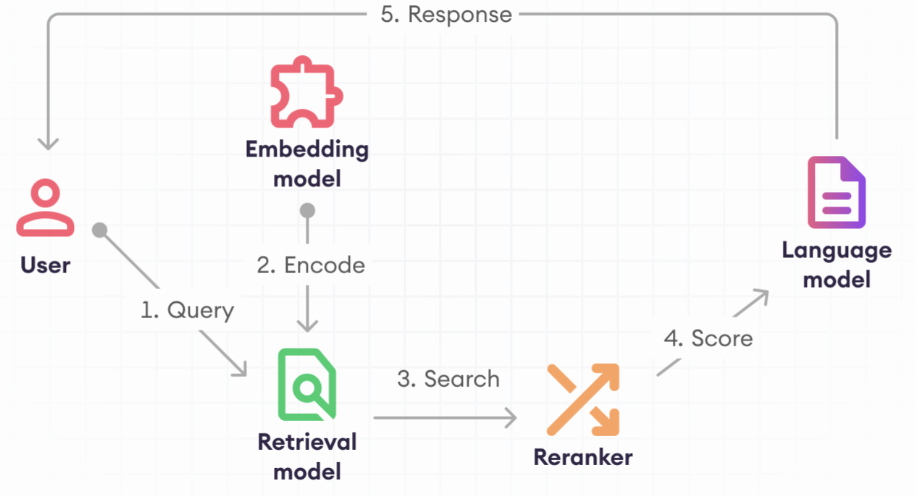

RAG brings together four key components:

* Embedding model: This is where documents are turned into vectors, or numerical representations, which make it easier for the system to manage and compare large amounts of text data.

* Retriever: Think of this as the search engine within RAG. It uses the embedding model to process a question and fetch the most relevant document vectors that match the query.

* Reranker (optional): This component takes things a step further by evaluating the retrieved documents to determine how relevant they are to the question at hand, providing a relevance score for each one.

* Language model: Finally, this part of the system takes the top documents provided by the retriever or reranker, along with the original question, and crafts a precise answer.

**Before getting started, if running on Google Colab, check that the runtime is set to T4 GPU**

## Install Dependencies
- Requirements for running Streamlit Server
- Requirements for creating a public model serving URL via Ngrok
- Requirements for running Local LLM (including Quantization)


In [ ]:
!python -V  #Python 3.10.12

In [ ]:

!nvcc --version # find the CUDA driver build above


In [1]:
!pip install --no-cache-dir llama-cpp-python==0.2.77 --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu121/

Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu121/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.1 MB/s eta 0:00:00


In [2]:
!pip install langchain
!pip install -U langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.3 MB/s eta 0:00:00


In [3]:
!pip install PyPDF2
!pip install sentence-transformers
!pip install tiktoken
!pip install qdrant-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.64.1
    Uninstalling grpcio-1.64.1:
      Successfully uninstalled grpcio-1.64.1
ERROR: pip's dependency resolver does not currently t

In [4]:
# If this complains about dependency resolver, it's safe to ignore
!pip install python-multipart transformers pydantic tensorflow streamlit



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.2
    Uninstalling protobuf-5.28.2:
      Successfully uninstalled protobuf-5.28.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-tools 1.66.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.5 which is incompatible.
tens

Ngrok is used to make the Streamlit server accessible via a public URL.

Users are required to make a free account and provide their auth token to use Ngrok. The free version only allows 1 local tunnel and the auth token is used to track this usage limit.

## Create Streamlit App
This provides an Streamlit Web App.

Download the LLM before you do next step.

In [5]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# !curl -L -O "https://huggingface.co/TheBloke/zephyr-7B-beta-GGUF/resolve/main/zephyr-7b-beta.Q6_K.gguf"
!curl -L -O "https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.1-GGUF/resolve/main/mistral-7b-instruct-v0.1.Q6_K.gguf"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1145  100  1145    0     0   5733      0 --:--:-- --:--:-- --:--:--  5725
100 5666M  100 5666M    0     0   163M      0  0:00:34  0:00:34 --:--:--  116M


## Start Streamlit
The initial run will take a long time due to having to download the model and load it onto GPU.

Note: interrupting the Google Colab runtime will send a SIGINT and stop the server.

In [7]:
# This cell finishes quickly because it just needs to start up the server
# The server will start the model download and will take a while to start up
# ~5 minutes
!streamlit run /content/app_rag.py &>/content/logs.txt &

Check the logs at server.log to see progress.

Wait until model is loaded and check with the next cell before moving on.

## Use Ngrok to create a public URL for the Streamlit server.
**IMPORTANT:** If you created an account via email, please verify your email or the next 2 cells won't work.

If you signed up via Google or GitHub account, you're good to go.

In [8]:
!pip install  nest-asyncio pyngrok

In [9]:
import nest_asyncio
from pyngrok import ngrok


# Get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
auth_token = "2L8zKsQFoQgdbLnb2WQnaeVY1Vd_42YZSA3kv76VYypy71BjE"

# Set the authtoken
ngrok.set_auth_token(auth_token)

# Connect to ngrok
ngrok_tunnel = ngrok.connect(8501)

# Print the public URL
print('Public URL:', ngrok_tunnel.public_url)

# Apply nest_asyncio
nest_asyncio.apply()

# Run the uvicorn server
# uvicorn.run(app, port=8000)

Public URL: https://605a-104-197-245-199.ngrok-free.app


## Shutting Down
To shut down the processes, run the following commands in a new cell:
```

!pkill ngrok
```

In [ ]:

!pkill ngrok